# Write a Machine Learning Algorithm from Scratch using Pure Python
## Handwritten Digit Recognition with Logistic Regression

In this notebook, I demonstrate how to write an image classification algorithm with logistic regression from scratch using Python and achieve high accuracy in the task of Handwritten Digit Recognition.

## What is Logistic Regression?

How is logistic regression different from linear regression? While linear regression is suited for estimating continuous values (e.g., house prices), Logistic Regression is used for predicting what would be the most probable class of an observed data point.

Logistic Regression is a variation of Linear Regression, useful when the observed dependent variable, y, is categorical. It produces a formula that predicts the probability of the class label as a function of the independent variables.

## Prepare Trainning Dataset

The data we are going to use to train our model is the MNIST handwritten digit database. First, download the images data files from [the MNIST database](http://yann.lecun.com/exdb/mnist/) and store them under the data/ directory. In this project, we use 8000 images for training and 2000 for testing. The image files are tables of a large set of images, each consisting of 28^2 pixels and each pixel is a 8-bit integer. 

In [3]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
# tensorflow is only used to easily download the training data
from tensorflow.keras.datasets import mnist

image_size = 28

def get_data(num_data=60000):
    num_test = num_data // 6
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    x_train = train_images[:num_data, :].reshape([num_data, 28*28]) / 255
    y_train = train_labels[:num_data]
    x_test = test_images[:num_test, :].reshape([num_test, 28*28]) / 255
    y_test = test_labels[:num_test]
    return x_train, y_train, x_test, y_test

# limit num_data to increase the speed of the code
x_train, y_train, x_test, y_test = get_data(3000)

In [7]:
x_train.shape, y_train.shape, x_train.min(), x_train.max()

((3000, 784), (3000,), 0.0, 1.0)

Let's visualize 10 images that is randomly picked. You will see the images match with the labels.

Labels:  [4 9 8 9 0 8 7 9 6 1]


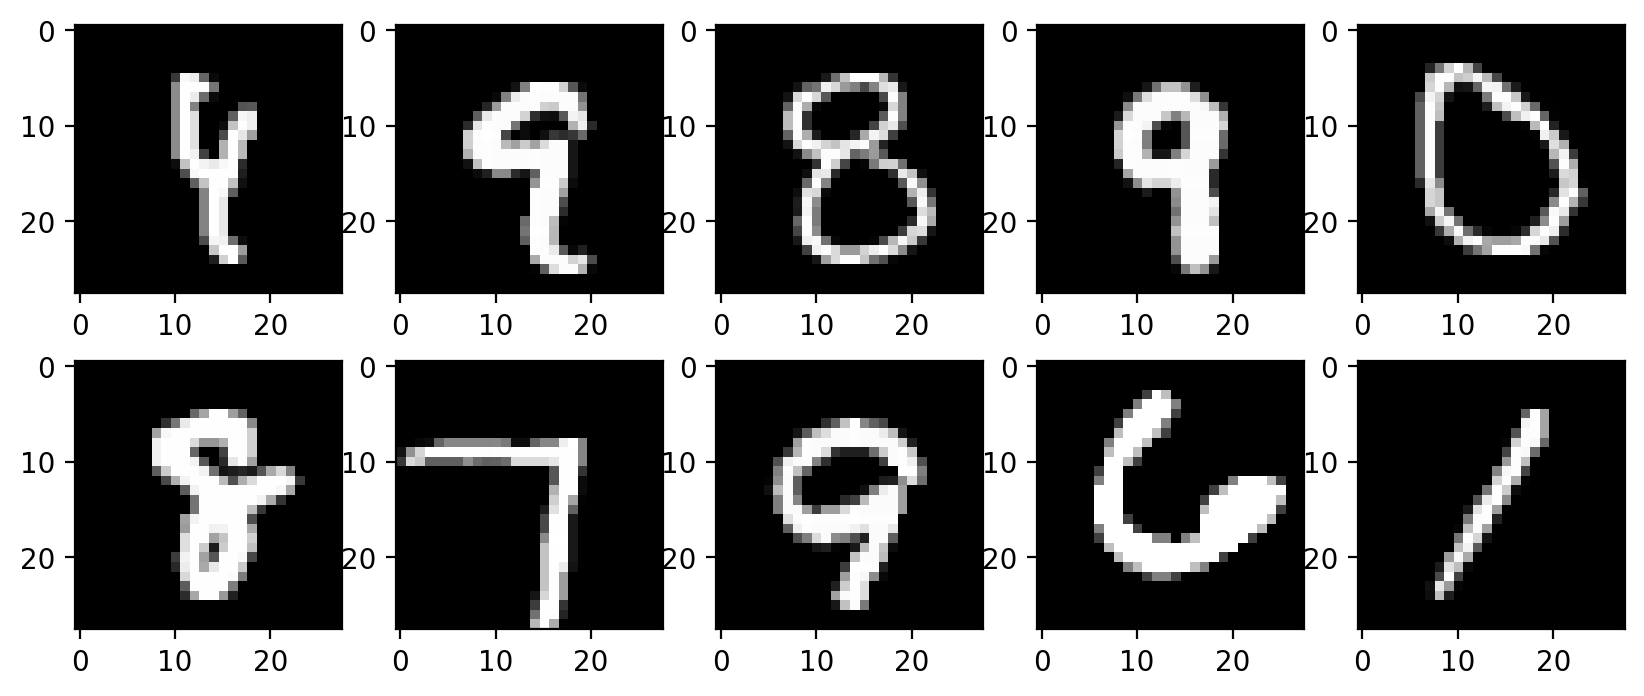

In [22]:
picks = np.random.choice(range(len(y_test)), 10)
f, axs = plt.subplots(2, 5, figsize=[10, 4])
for i, ax in enumerate(axs.flatten()):
    ax.set_aspect('equal', 'box')
    ax.imshow(x_test[picks[i], :].reshape(image_size, image_size), cmap="gray")
print("Labels: ", y_test[picks])
plt.show()

## Training a binary classification model

We begin with a simpler version of the task: binary classification. In a binary classification model, we estimate the probability of some event being true. In this case, we tell if or not an image corresponds to the digit "1". That means, the model will return 1 if the digit is 1 and 0 otherwise. We keep only 1's in the labels and the rest is set to zero. In the next section, we will extend the model to recoganizing all 10 digits.

We first reset the labels.

In [23]:
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()
y_train_binary[y_train_binary != 1] = 0
y_test_binary[y_test_binary != 1] = 0
print("Original labels:", y_test[picks])
print("Binary labels:", y_test_binary[picks])

Original labels: [4 9 8 9 0 8 7 9 6 1]
Binary labels: [0 0 0 0 0 0 0 0 0 1]


The training and test datasets are ready to be used in the model. Let us develop the model.

### Linear regression

The logistic regression uses the basic linear regression formula that we all learned in high school: $y = a x + b$. In logistic regression variables are expressed in vectors:
$$
z = {\boldsymbol w}^T {\boldsymbol x} + b
$$

Here $z$ is the output variable, $x$ is the input variable, $w$ and $b$ are model parameters. Here $b$ is scalar and both $x$ and $w$ are **column vectores**:

$$
{\displaystyle {\boldsymbol {x}}={\begin{bmatrix}x_{1}\\ x_{2}\\
\vdots\\ x_{m}\end{bmatrix}}\,.}
$$

Therefore $w^T x$ means multiply all the elements of $w$ by all the elements of $x$ and add them together.

### Activation function: Sigmoid function

This output z is passed through a non-linear function. The commonly used nonlinear function is the sigmoid function that returns a value between 0 and 1.

$$
y_{\rm predict} \equiv a = \frac{1}{1 + e^{-z}}.
$$

In [24]:
def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    return s

### Cost Function

The cost function is a measure of a model that reflects how much the predicted output differs from the original output. The purpose of the training is to reduce the cost function as much as possible. Here is the formula for the cost function of one training example or one row of data:

$$
J(a, y) = - y \log a - (1 - y) \log (1 - a),
$$

and the average cost function for all the rows is

$$
J = \frac{1}{m} \Sigma_{i=1}^{m} J(a, y).
$$

Here $a$ is the sigmoid function from above and $y$ is the label of the training data: 0 or 1. Note how a large $a$ with $y = 1$ or a small $a$ with $y = 0$ reduces $J$.

A special procedure here is conserved with zero values in the log function. Althrough mathematically $a$ takes values in the range (0, 1), not including 0 or 1, in practice, roundoff error could cause $a = 0$ when $z$ is very small or $a = 1$ when $z$ is large. To avoid `J = NaN` in the program, we wrap the Sigmoid function in the following functions: `log(a(z)) = - special.logsumexp([0, -z])`. See [this page](https://fa.bianp.net/blog/2019/evaluate_logistic/) for details.

In [25]:
def logsig_lin(z):
    # log(1 / (1 + np.exp(-z))
    return - special.logsumexp([0, -z])

def log1minussig_lin(z):
    # log(1 - 1 / (1 + np.exp(-z))
    return -z - special.logsumexp([0, -z])

logsig = np.vectorize(logsig_lin)
log1minussig = np.vectorize(log1minussig_lin)

### Gradient descent

The goal of model traning is to update the variables `w` and `b` in order to reduce the cost function. They would be initialized as zeros but need to be updated later with better values. Gradient descent will help with that. Let’s see how.

We have expressed the cost function as a function of `a` and `y`, but it can be expressed as a function of `w` and `b` as well, because `a` is derived from `w` and `b`.

$$
\frac{\partial J(a, y)}{\partial w} = \frac{d J(a, y)}{d a} \frac{da}{dz} \frac{\partial z}{\partial w} = x(a - y)
$$

$$
\frac{\partial J(a, y)}{\partial b} = \frac{d J(a, y)}{d a} \frac{da}{dz} \frac{\partial z}{\partial b} = a - y
$$

Therefore,

$$
\frac{\partial J}{\partial w} = \frac{1}{m} (a - {\bf y})^T \cdot {\bf x}
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \Sigma_{i=1}^{m} (a - y)
$$

Now, we can write a function to calculate the derivatives of $J$ given the current parameters, w and
b, and training dataset, X and Y:

In [26]:
def propagate(w, b, X, Y):
    # the number of training data
    m = X.shape[0]
    # calculate the predicted output
    z = np.dot(w.T, X.T) + b
    A = sigmoid(z)
    # calculate the cost function
    cost = -1/m * np.sum(Y * logsig(z) + (1 - Y) * log1minussig(z))
    # calculate the gradients
    dw = 1/m * np.dot(X.T, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    return dw, db, cost

### Optimize the parameters to best fit the training data

In [27]:
def optimize(w, b, X, Y, num_ite, rate):
    costs = []
    for i in range(num_ite):
        dw, db, cost = propagate(w, b, X, Y)
        # update w and b y deducting the dw and db times learning rate from the previous values
        w -= rate * dw
        b -= rate * db
        # record the cost function value for each 10 iterations
        if i % 10 == 0:
            costs.append(cost)
            print(f"Iteration: {i}, cost = {cost}")
    # The final updated parameters and gradients
    params = {'w': w, 'b': b}
    grads = {"dw": dw, "db": db}
    return params, grads, costs

We also need a function to predict the output given the model parameters.

In [28]:
def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X.T) + b)[0]
    # Iterating through A and predict an 1 if the value of A is greater than 0.5 and a 0 otherwise
    return np.array(A > 0.5, dtype=int)

The final function to do the model and print its accuracy:

In [29]:
# dim = 28^2
dim = x_train.shape[1]
# Initializing the w and b as zeros
w = np.zeros([dim, 1])
b = 0
num_ite = 100
rate = 1

# dw, db, cost = propagate(w, b, x_train, y_train_binary)
# print(dw.shape, db.shape, cost.shape)

# Train the model
params, grads, costs = optimize(w, b, x_train, y_train_binary, num_ite, rate)
# Make predictions based on the trained parameters
prediction_train = predict(params['w'], params['b'], x_train)
prediction_test = predict(params['w'], params['b'], x_test)
# Print out the accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(prediction_train - y_train_binary)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(prediction_test - y_test_binary)) * 100))
print("Predictions for the picked images:", prediction_test[picks], ", compared to the labels:", y_test_binary[picks])

Iteration: 0, cost = 0.6931471805599453
Iteration: 10, cost = 0.055226474813868796
Iteration: 20, cost = 0.04912312287722341
Iteration: 30, cost = 0.04551809803578698
Iteration: 40, cost = 0.043016920822440206
Iteration: 50, cost = 0.04113046482258539
Iteration: 60, cost = 0.03962767358714186
Iteration: 70, cost = 0.03838346260933494
Iteration: 80, cost = 0.0373236170269816
Iteration: 90, cost = 0.03640097126467271
train accuracy: 99.1 %
test accuracy: 98.66666666666667 %
Predictions for the picked images: [0 0 0 0 0 0 0 0 0 1] , compared to the labels: [0 0 0 0 0 0 0 0 0 1]


### Visualization of the cost (loss) function

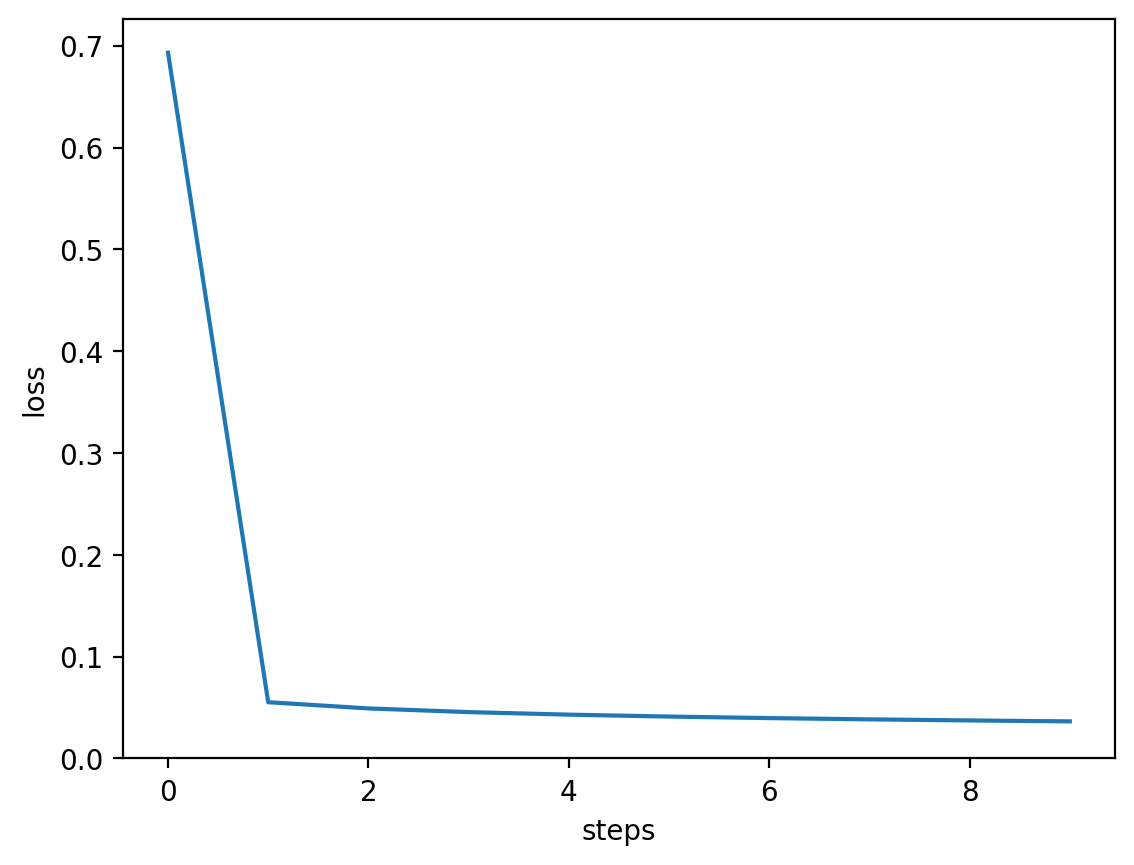

In [33]:
plt.plot(costs)
plt.gca().set(xlabel="steps", ylabel="loss", ylim=[0, None])
plt.savefig("out/f2.png", dpi=300)

## Training a multi-class classification model

Now it is time to extend our model capability to do a complete image classification. The idea is to optimize the parameters for each individual catagories, in this case 0, 1, 2, ... 9. In the prediction, we find the catogary with the highest probability (Sigmoid value $a(z)$).

First, rebuild the y data

In [34]:
# build y
N = 10  # number of labels
y_train_sparse = np.zeros([N, len(y_train)])
for i in range(len(y_train)):
    y_train_sparse[int(y_train[i]), i] = 1
y_test_sparse = np.zeros([N, len(y_test)])
for i in range(len(y_test)):
    y_test_sparse[int(y_test[i]), i] = 1

and the new optimize and predict function

In [35]:
def propagate_multi(w, b, X, Y):
    """
    Params:
        w: (d by N) d is the number of dimensions (pixels), N is the number of catagories (10)
        b: (N)
        X: (d by m) m is the number of data
        Y: (N by m)
        
    Return:
        dw: (d by N)
        db: (N)
        cost: (float)
    """
    # the number of training data
    m = X.shape[0]
    # calculate the predicted output
    z = (np.dot(w.T, X.T).T + b).T # (N by m)
    A = sigmoid(z)
    cost = -1 / (N * m) * np.sum(Y * logsig(z) + (1 - Y) * log1minussig(z))
    # calculate the gradients
    dw = 1/m * np.dot(X.T, (A - Y).T) # (d by N)
    db = 1/m * np.sum(A - Y, axis=1) # (N)
    return dw, db, cost

def optimize(w, b, X, Y, num_ite, rate, cost_skip=10):
    # costs = []
    for i in range(num_ite):
        dw, db, cost = propagate_multi(w, b, X, Y)
        # update w and b y deducting the dw and db times learning rate from the previous values
        w -= rate * dw
        b -= rate * db
        # record the cost function value for each 100 iterations
        # if i % 5 == 0:
        #     costs.append(cost)
        #     print(f"Iteration: {i}, cost = {cost}")
    # The final updated parameters and gradients
    params = {'w': w, 'b': b}
    grads = {"dw": dw, "db": db}
    return params, grads, cost

def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X.T).T + b).T # (N by m)
    return  np.argmax(A, axis=0) # (m)

Now, train the model

iteration 1, cost = 0.69315, train accuracy = 70.6 %
iteration 2, cost = 0.54894, train accuracy = 71.0 %
iteration 3, cost = 0.38129, train accuracy = 71.6 %
iteration 4, cost = 0.26059, train accuracy = 75.5 %
iteration 5, cost = 0.21668, train accuracy = 80.2 %
iteration 6, cost = 0.20278, train accuracy = 81.2 %
iteration 7, cost = 0.19270, train accuracy = 82.0 %
iteration 8, cost = 0.18434, train accuracy = 82.5 %
iteration 9, cost = 0.17723, train accuracy = 82.8 %
iteration 10, cost = 0.17111, train accuracy = 83.1 %
iteration 11, cost = 0.16577, train accuracy = 83.4 %
iteration 12, cost = 0.16106, train accuracy = 83.8 %
iteration 13, cost = 0.15687, train accuracy = 84.1 %
iteration 14, cost = 0.15311, train accuracy = 84.3 %
iteration 15, cost = 0.14971, train accuracy = 84.6 %
iteration 16, cost = 0.14662, train accuracy = 84.8 %
iteration 17, cost = 0.14380, train accuracy = 85.1 %
iteration 18, cost = 0.14120, train accuracy = 85.2 %
iteration 19, cost = 0.13880, train a

[None, Text(0.5, 0, 'steps'), Text(0, 0.5, 'loss'), (0.0, 0.7217711285910253)]

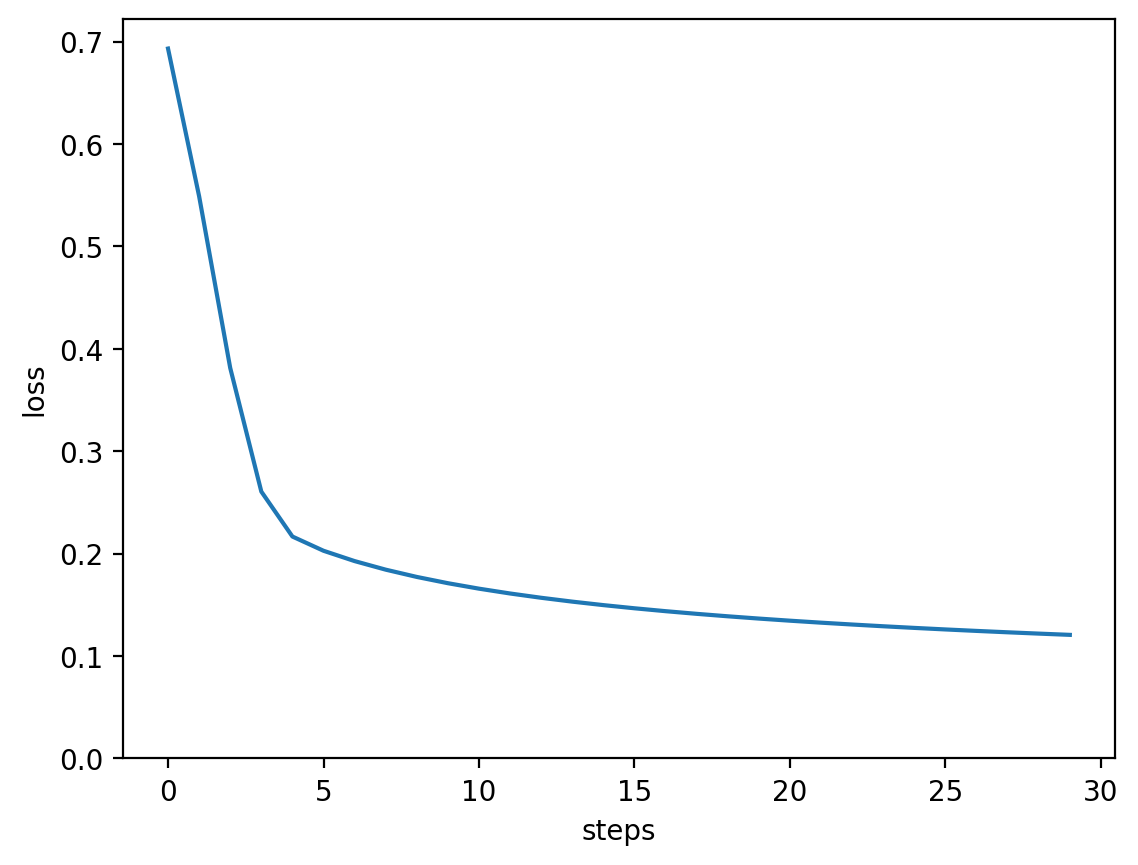

In [38]:
# test: find the best num_ite

N = 10
# Initializing the w and b as zeros
dim = x_train.shape[1]
w = np.zeros([dim, N])
b = np.zeros(N)
rate = 0.4
params = {'w': w, 'b': b}
ite_per_cycle = 1
iterations = 30
costs = []
for cycle in range(iterations):
    params, grads, cost = optimize(params['w'], params['b'], x_train, y_train_sparse, ite_per_cycle, rate)
    costs.append(cost)
    prediction_train = predict(params['w'], params['b'], x_train)
    print("iteration {}, cost = {:.5f}, train accuracy = {:.1f} %".format(
        (cycle + 1) * ite_per_cycle,
        cost,
        np.sum(prediction_train == np.array(y_train, dtype=int)) / len(y_train) * 100))
prediction_test = predict(params['w'], params['b'], x_test)
print("test accuracy: {} %".format(np.sum(prediction_test == np.array(y_test, dtype=int)) / len(y_test) * 100))
print("Predictions for the picked images:", prediction_test[picks], ", compared to the labels:", y_test[picks])

plt.plot(costs)
plt.gca().set(yscale='linear', xlabel="steps", ylabel="loss", ylim=[0, None])
# plt.savefig("f2.png", dpi=300)

Here we get 80% accuracy on the test data. With properly setting the learning rate and increase the number of iteration, it's possible to reach 90% accuracy

## Why did it work?

How could such a simple model achieve such high accuracy in classifying handwritten digits, given the high complexity and variation in the handwritten digits? We can have an appreciation of how it works by taking a visualization of the weight. Recall the each weight correponds to how much each of the input pixels are taken into account. By reshaping the wegiths into a 28 by 28 image, we can tell what pixels are most important and least important:

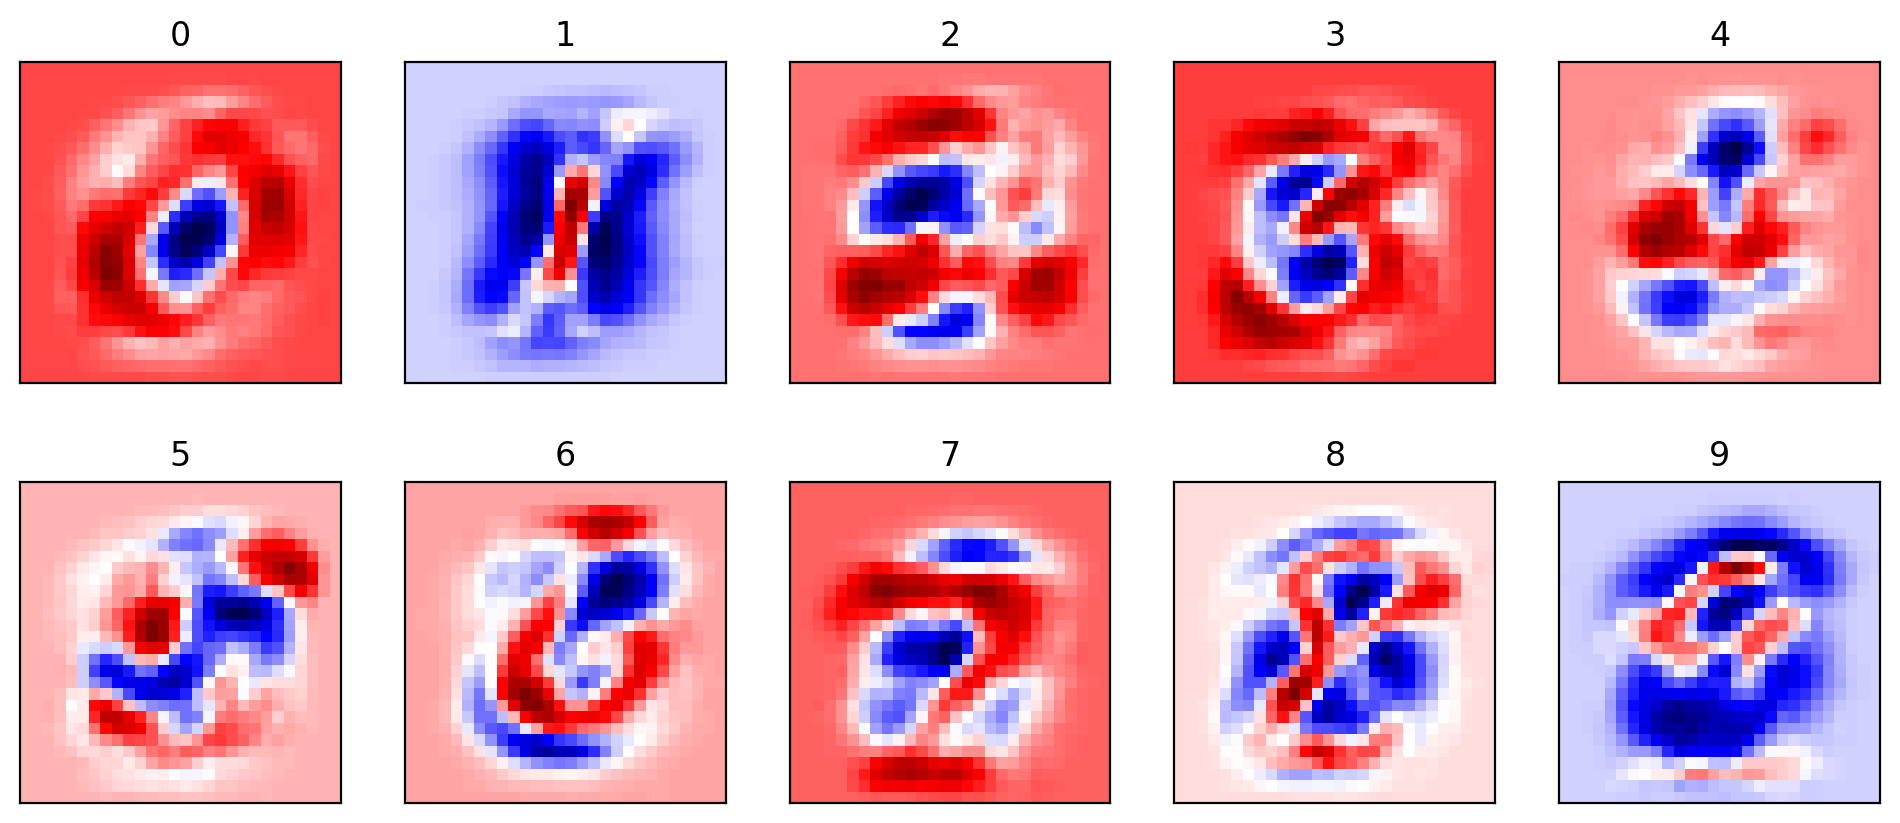

In [42]:
plt.figure(figsize=[12, 5])
for i in range(N):
    plt.subplot(2, 5, i+1)
    weight = params['w'][:, i].reshape([image_size, image_size])
    plt.title(i)
    plt.imshow(weight, cmap="seismic", )
    ax = plt.gca().axes
    ax.get_xaxis().set_visible(0)
    ax.get_yaxis().set_visible(0)
# print("b =", params['b'])
plt.savefig("out/f3.png", dpi=300)

Here the colors are weights with red meaning positive and blue meaning negative values. Note how the weights of some of the digits (0, 1, 3, 5, 7, 8) are interpretable. Other digits are more complicated, which might be the reason why the algorithm could not reach very high accuracy.

# MNIST Image Classification using Neural Networks via Tensorflow (Keras)

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

2023-03-07 02:15:55.044039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Reproducing logistic regression using Tensorflow

Train the same data set using a single model (instead of 10 independent model) where the loss function is measured by a **softmax** function. 

In [10]:
x_train, y_train, x_test, y_test = get_data()
y_train_sparse = preprocessing.label_binarize(y_train, classes=np.arange(10, dtype=int))
y_test_sparse = preprocessing.label_binarize(y_test, classes=np.arange(10, dtype=int))

In [12]:
model = Sequential()
dim = 28*28
model.add(layers.InputLayer(input_shape=(dim,)))
model.add(layers.Dense(10, activation='sigmoid', input_shape=(dim,)))
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train_sparse,
          validation_data=(x_test, y_test_sparse),
          epochs=3,
          )

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4731 - accuracy: 0.8771 - val_loss: 0.3058 - val_accuracy: 0.9157
Epoch 2/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3040 - accuracy: 0.9149 - val_loss: 0.2832 - val_accuracy: 0.9214
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2833 - accuracy: 0.9209 - val_loss: 0.2723 - val_accuracy: 0.9237


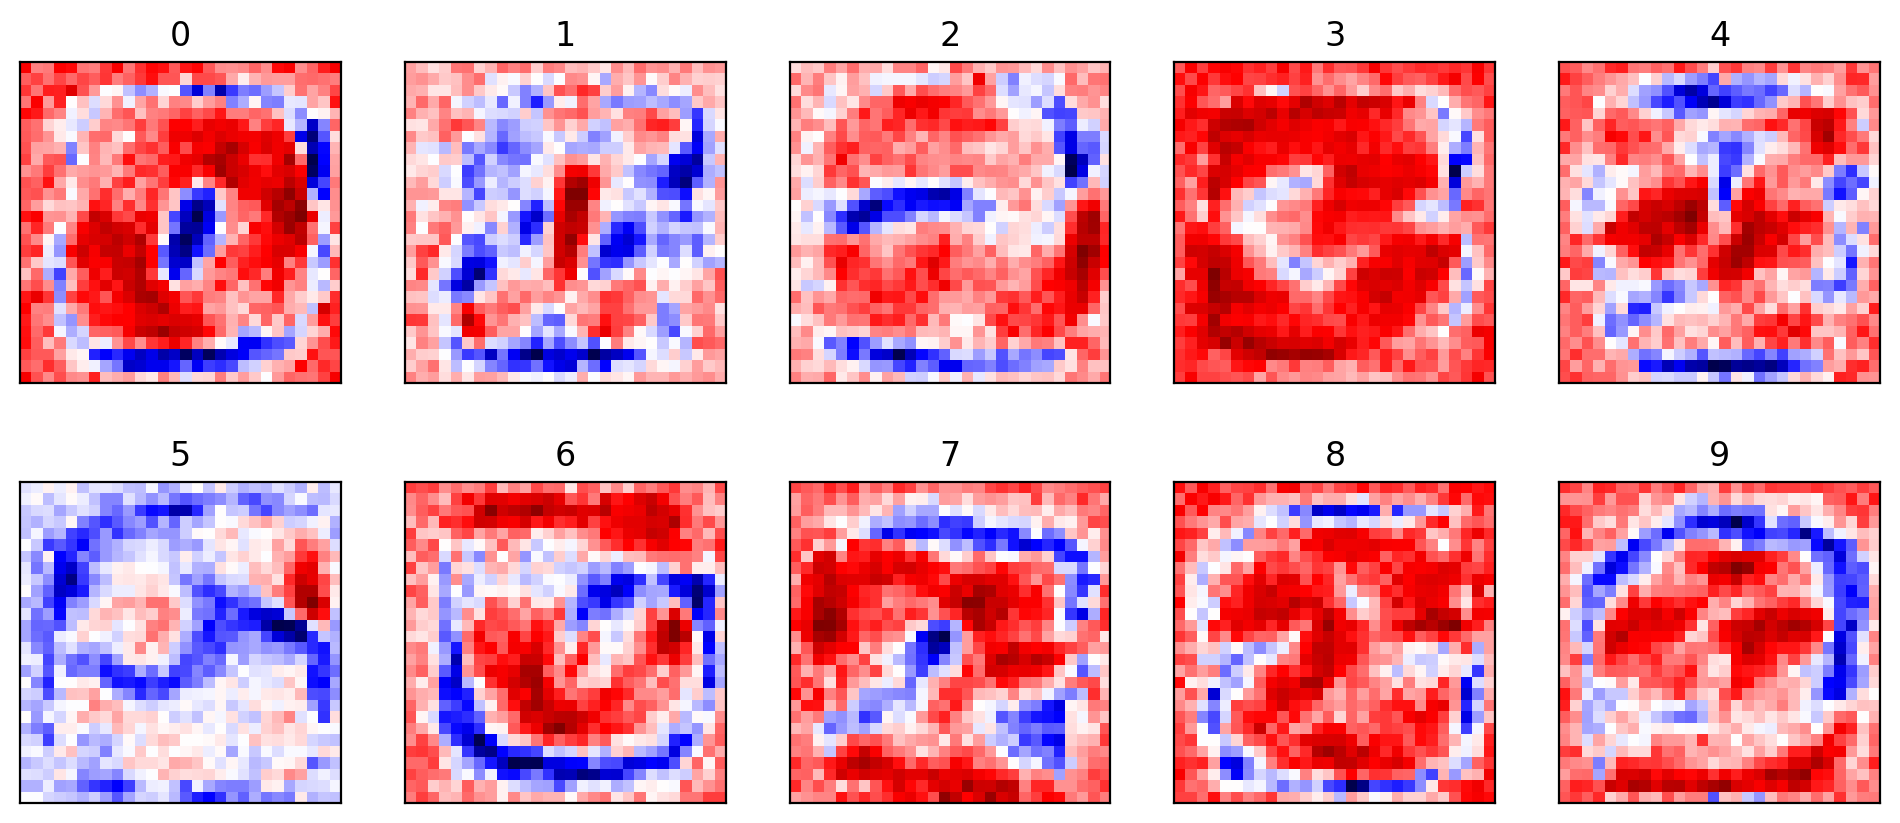

In [18]:
weights = model.layers[0].get_weights()[0]
plt.figure(figsize=[12, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = weights[:, i].reshape([image_size, image_size])
    plt.title(i)
    plt.imshow(weight, cmap="seismic", )
    ax = plt.gca().axes
    ax.get_xaxis().set_visible(0)
    ax.get_yaxis().set_visible(0)
# print("b =", params['b'])
plt.savefig("out/f4.png", dpi=300)

### Artificial Neural Network

Prepare the training data

In [19]:
# load training data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocessing training data
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
train_images = train_images.astype('float32') / 255

# Preprocessing test data
test_images = test_images.reshape((test_images.shape[0], 28 * 28))
test_images = test_images.astype('float32') / 225

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels  = keras.utils.to_categorical(test_labels)

print('train_images shape:', train_images.shape)
print('labels shape:', train_labels.shape)

train_images shape: (60000, 784)
labels shape: (60000, 10)


### Build the Artificial Neural Network (ANN) model

<center><img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*WfERQXN_BtLi1eAh36_mvw.png" width="400"/></center>

Build the model and compile

In [20]:
model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28, )))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics = ['accuracy'],
             )

Train the model.

In [21]:
model.fit(train_images, train_labels, 
          epochs=5, 
          validation_data=(test_images, test_labels),
          batch_size=128)

Epoch 1/5
469/469 [==============================] - 3s 6ms/step - loss: 0.2642 - accuracy: 0.9237 - val_loss: 0.1204 - val_accuracy: 0.9652
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1071 - accuracy: 0.9690 - val_loss: 0.0968 - val_accuracy: 0.9697
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0703 - accuracy: 0.9797 - val_loss: 0.0782 - val_accuracy: 0.9757
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0504 - accuracy: 0.9847 - val_loss: 0.0712 - val_accuracy: 0.9789
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.0381 - accuracy: 0.9886 - val_loss: 0.0631 - val_accuracy: 0.9805


98% accuracy, easily!

![](./out/MNIST.gv.png)

In [25]:
model.save('out/mnist.h5')

### Interpretability?

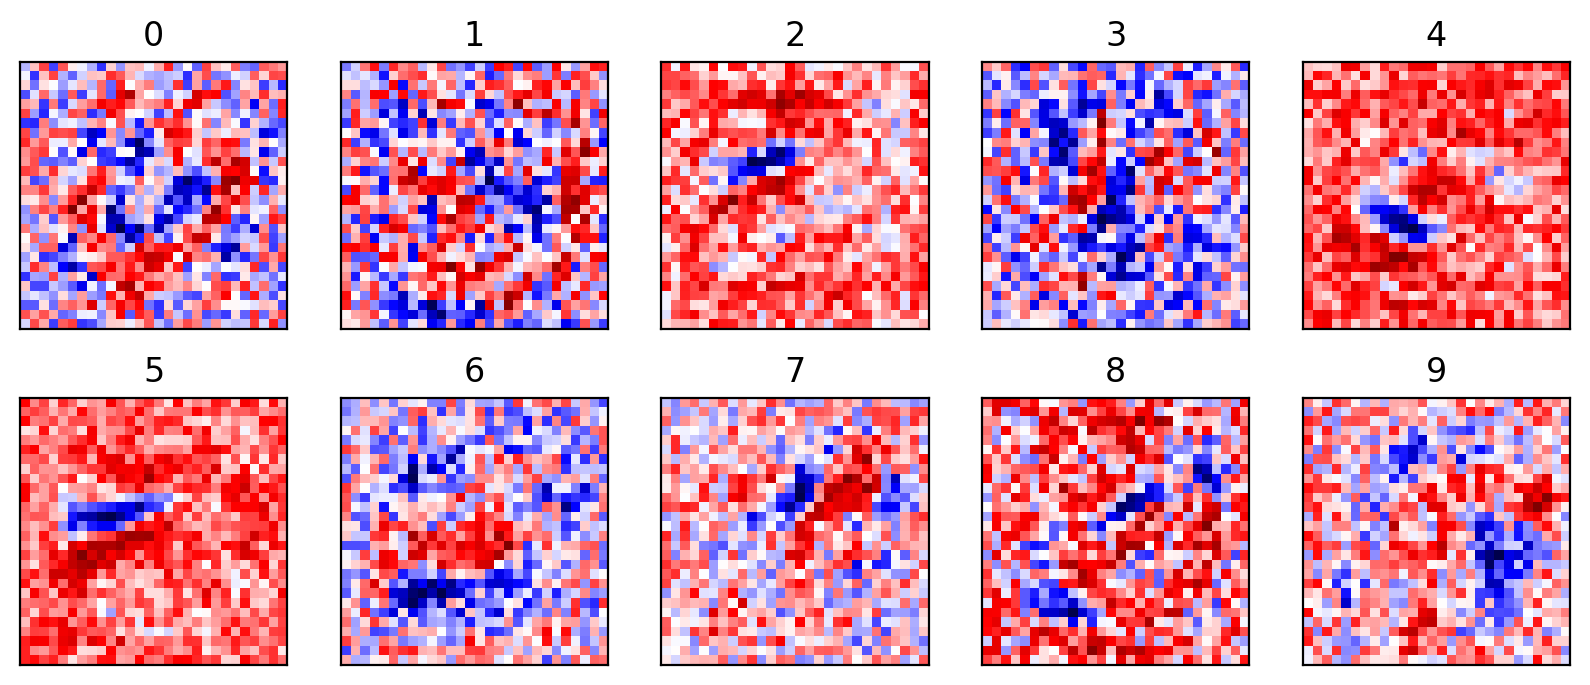

In [27]:
plt.figure(figsize=[10, 4])
params = np.array(model.layers[0].weights[0])
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = params[:, i].reshape([28, 28])
    plt.title(i)
    plt.imshow(weight, cmap="seismic", )
    ax = plt.gca().axes
    ax.get_xaxis().set_visible(0)
    ax.get_yaxis().set_visible(0)

### Apply this model in real time

In [28]:
import os
import numpy as np
from PIL import ImageGrab, Image
from tensorflow.keras.models import load_model

model = load_model('out/mnist.h5')
def predict_digit(img, reverse=False):
    # img: PIL.Image instance of rgb image with 28x28 pixels
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    img = img.reshape(1,28 * 28,1)
    img = img/255.0
    if reverse:
        img = 1 - img
    #predicting
    res = model.predict([img])[0]
    return np.argmax(res), max(res)
# Image.open() can also open other image types
img = Image.open("img-0.png")
print(predict_digit(img))
img = Image.open("img-9.png")
print(predict_digit(img))

1/1 [==============================] - 0s 94ms/step
(0, 0.99999917)
1/1 [==============================] - 0s 19ms/step
(9, 0.99904984)


Try inputing a image from a totally different distribution

In [33]:
img = Image.open("img-0-inverted.png")
print(predict_digit(img))

1/1 [==============================] - 0s 39ms/step
(8, 0.5655792)


ANN made a *wrong* prediction with 99% confidence! 

In [29]:
try:
    while True:
        path = input("Path to your image:")
        img = Image.open(path)
        print("Prediction and probability:", 
              predict_digit(img, reverse=True))
except KeyboardInterrupt:
    pass

Path to your image: /Users/chongchonghe/Library/Application Support/CleanShot/media/media_z0VA5Q9TP5/CleanShot_2023-03-06_at_23.32.04.png


1/1 [==============================] - 0s 24ms/step
Prediction and probability: (6, 0.997766)


Path to your image: /Users/chongchonghe/Library/Application Support/CleanShot/media/media_q8dPZm1svg/CleanShot_2023-03-06_at_23.33.35.png


1/1 [==============================] - 0s 20ms/step
Prediction and probability: (8, 0.9999312)


### CNN?

![cnn](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*nQ9oyvewy_c5-2bK9-UtOg.png)

Reload the images with the original square shape

In [36]:
# load training data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocessing training data
# train_images = train_images.reshape((train_images.shape[0], 28 * 28))
train_images = train_images.astype('float32') / 255

# Preprocessing test data
# test_images = test_images.reshape((test_images.shape[0], 28 * 28))
test_images = test_images.astype('float32') / 225

train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels  = keras.utils.to_categorical(test_labels)

print('train_images shape:', train_images.shape)
print('labels shape:', train_labels.shape)

train_images shape: (60000, 28, 28)
labels shape: (60000, 10)


In [37]:
LeNet5Model = Sequential([

# Layer 1
layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', 
              input_shape = (28,28,1), name = 'convolution_1'),
layers.MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),

# Layer 2
layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu', 
              name = 'convolution_2'),
layers.MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),

# Layer 3
layers.Flatten(name = 'flatten'),
layers.Dense(units = 120, activation = 'relu', name = 'fully_connected_1'),

# Layer 4
layers.Dense(units = 84, activation = 'relu', name = 'fully_connected_2'),

# Output
layers.Dense(units = 10, activation = 'softmax', name = 'output')

])

LeNet5Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

LeNet5Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 24, 24, 6)         156       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 6)         0         
                                                                 
 convolution_2 (Conv2D)      (None, 8, 8, 16)          2416      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 4, 4, 16)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 fully_connected_1 (Dense)   (None, 120)               30840     
                                                                 
 fully_connected_2 (Dense)   (None, 84)               

![CNN](http://rpmarchildon.com/wp-content/uploads/2018/06/RM-CNN-Schematic-1.jpg)

In [38]:
history = LeNet5Model.fit(train_images, train_labels, 
                          epochs = 5, 
                          batch_size = 128,
#                           callbacks = [variable_learning_rate], 
                          validation_data=(test_images, test_labels),
                          )

Epoch 1/5
469/469 [==============================] - 12s 23ms/step - loss: 0.3325 - accuracy: 0.9008 - val_loss: 0.0929 - val_accuracy: 0.9710
Epoch 2/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0909 - accuracy: 0.9717 - val_loss: 0.0603 - val_accuracy: 0.9806
Epoch 3/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0637 - accuracy: 0.9800 - val_loss: 0.0620 - val_accuracy: 0.9808
Epoch 4/5
469/469 [==============================] - 11s 24ms/step - loss: 0.0513 - accuracy: 0.9834 - val_loss: 0.0499 - val_accuracy: 0.9852
Epoch 5/5
469/469 [==============================] - 11s 23ms/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.0425 - val_accuracy: 0.9875


# Train a physical model

Here I train a model to predict if or not two stars are gravitationally bound to each other. 

In [34]:
# import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn import preprocessing
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.optimizers import Adam

In [49]:
#---------- prepare data and labels ----------

def generate_binaries(N):
    par1 = np.random.randn(N, 7)     # m, x, y, z, vx, vy, vz
    par2 = np.random.randn(N, 7)     # m, x, y, z, vx, vy, vz
    par1[:, 0] = np.random.random(N) * 20
    par2[:, 0] = np.random.random(N) * 20
    return par1, par2

def is_bound(par1, par2):
    kin, pot = cal_kin_pot(par1, par2)
    return kin + pot < 0

def cal_kin_pot(par1, par2):
    m1 = par1[:, 0]
    m2 = par2[:, 0]
    kin = 0.5 * m1 * np.sum(par1[:, 4:7]**2, axis=1) + \
          0.5 * m2 * np.sum(par2[:, 4:7]**2, axis=1)
    pot = -1 * m1 * m2 / norm(par1[:, 1:4] - par2[:, 1:4], axis=1)
    return kin, pot

N = 2**18
dim = 14
par1, par2 = generate_binaries(N)
data = np.hstack((par1, par2))    # dim: N by 14
assert data.shape == (N, dim), data.shape
bound = is_bound(par1, par2)
labels = np.zeros(N, dtype=int)
labels[bound] = 1
print("Fraction of bound binaries is", np.sum(labels) / len(labels))

# show a table
kin, pot = cal_kin_pot(par1, par2)
demo = np.vstack((kin, pot, kin + pot, labels)).T
df = pd.DataFrame(demo, columns=["kin", "pot", "tot", "bound?"])
print(df)

# finally, process the data
scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)

Fraction of bound binaries is 0.611175537109375
              kin         pot         tot  bound?
0       44.108866 -145.894882 -101.786016     1.0
1       34.671403  -61.075544  -26.404141     1.0
2       35.844725 -171.848661 -136.003937     1.0
3       29.386352  -71.979462  -42.593110     1.0
4       18.556937  -27.933244   -9.376308     1.0
...           ...         ...         ...     ...
262139   2.672109   -9.096513   -6.424404     1.0
262140  38.271294   -4.914257   33.357037     0.0
262141  68.449127 -144.841343  -76.392216     1.0
262142  42.112545  -51.775646   -9.663100     1.0
262143  28.365838 -148.255253 -119.889415     1.0

[262144 rows x 4 columns]


Epoch 1/5
5735/5735 [==============================] - 10s 2ms/step - loss: 0.2778 - accuracy: 0.8806 - val_loss: 0.2326 - val_accuracy: 0.9042
Epoch 2/5
5735/5735 [==============================] - 9s 2ms/step - loss: 0.2327 - accuracy: 0.9022 - val_loss: 0.2080 - val_accuracy: 0.9097
Epoch 3/5
5735/5735 [==============================] - 9s 2ms/step - loss: 0.2292 - accuracy: 0.9051 - val_loss: 0.2447 - val_accuracy: 0.9024
Epoch 4/5
5735/5735 [==============================] - 10s 2ms/step - loss: 0.2268 - accuracy: 0.9066 - val_loss: 0.2827 - val_accuracy: 0.8918
Epoch 5/5
5735/5735 [==============================] - 11s 2ms/step - loss: 0.2286 - accuracy: 0.9063 - val_loss: 0.1999 - val_accuracy: 0.9156
Done!


(0.0, 0.28035374730825424)

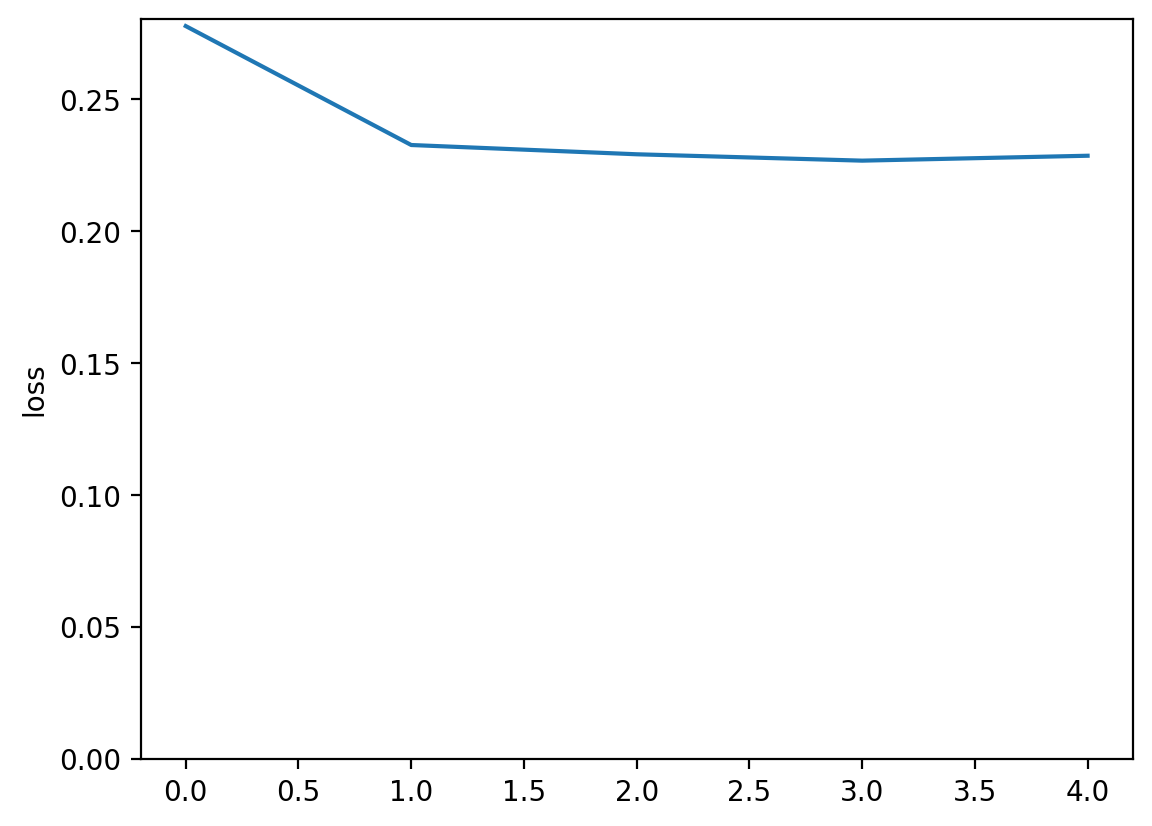

In [51]:
x_train, x_test, y_train, y_test = train_test_split(
    data_scaled, labels, test_size=0.3, random_state=0)

# Train it with Tensorflow
dim = x_train.shape[-1]
model = Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(dim,)))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# compile model
opt = Adam(learning_rate=0.05)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# fit the model. Keras ignores the first dimension, which is the batch size
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=5,
          )
print("Done!")

plt.figure()
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.ylim([0, None])

Simply increasing the number of layers and neurons does not help in this setup, although I'm pretty sure with a property setup of the layers, it should work and achieve high accuracy.

In [53]:
dim = 5
new_data = np.zeros([N, dim])
new_data[:, 0] = data[:, 0]
new_data[:, 1] = data[:, 7]
new_data[:, 2] = np.sum(data[:, 4:7]**2, axis=1)
new_data[:, 3] = np.sum(data[:, 11:14]**2, axis=1)
# new_data[:, 4] = - data[:, 0] * data[:, 7] / \
#                  norm(data[:, 1:4] - data[:, 8:11], axis=1)
new_data[:, 4] = norm(data[:, 1:4] - data[:, 8:11], axis=1)
# show a table of the new data
df = pd.DataFrame(np.hstack((new_data, labels.reshape((N, 1)))), 
                  columns=["mass_1", "mass_2", "v_squred_1", "v_squared_2", "distance", "bound?"])
print(df)

           mass_1     mass_2  v_squred_1  v_squared_2  distance  bound?
0       17.803928  18.859630    2.112963     2.682910  2.301489     1.0
1       10.424729  17.188661    5.594550     0.641187  2.933861     1.0
2       17.196197  14.877338    3.197521     1.122799  1.488715     1.0
3        8.517804  15.053129    3.036851     2.185951  1.781336     1.0
4        5.159905  15.702227    4.731940     0.808644  2.900559     1.0
...           ...        ...         ...          ...       ...     ...
262139   1.294827  14.835008    0.440774     0.321772  2.111663     1.0
262140  15.173999   0.706698    4.892202     3.266339  2.182107     0.0
262141  18.534643  18.822847    6.826390     0.551115  2.408668     1.0
262142  13.288322   8.634497    2.375316     6.098923  2.216061     1.0
262143   8.693922   4.073481    6.028932     1.059686  0.238875     1.0

[262144 rows x 6 columns]


In [54]:
scaler = preprocessing.StandardScaler().fit(new_data)
data_scaled = scaler.transform(new_data)
x_train, x_test, y_train, y_test = train_test_split(
    data_scaled, labels, test_size=0.3, random_state=0)

model = Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(dim,)))
model.add(layers.Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=5,
          )

Epoch 1/5
5735/5735 [==============================] - 10s 2ms/step - loss: 0.1072 - accuracy: 0.9622 - val_loss: 0.0661 - val_accuracy: 0.9766
Epoch 2/5
5735/5735 [==============================] - 10s 2ms/step - loss: 0.0578 - accuracy: 0.9807 - val_loss: 0.0508 - val_accuracy: 0.9826
Epoch 3/5
5735/5735 [==============================] - 9s 2ms/step - loss: 0.0487 - accuracy: 0.9830 - val_loss: 0.0476 - val_accuracy: 0.9813
Epoch 4/5
5721/5735 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9843

KeyboardInterrupt: 

## Sources

1. [Going beyond 99% — MNIST Handwritten Digits Recognition](https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392)
2. Sigmoid and SoftMax Functions in 5 minutes: [link](https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9#:~:text=Sigmoid%20is%20used%20for%20binary,extension%20of%20the%20Sigmoid%20function.)
3. Replicate a Logistic Regression Model as an Artificial Neural Network in Keras Neural Networks and Deep Learning Course: Part 11 [link](https://towardsdatascience.com/replicate-a-logistic-regression-model-as-an-artificial-neural-network-in-keras-cd6f49cf4b2c)
4. [Deep Learning: Overview of Neurons and Activation Functions](https://srnghn.medium.com/deep-learning-overview-of-neurons-and-activation-functions-1d98286cf1e4)
5. [Super-Resolution with TensorFlow](https://dzlab.github.io/notebooks/tensorflow/generative/artistic/2021/05/10/Super_Resolution_SRCNN.html)